In [ ]:
""" details dataset

    Presentation of the experiment
        Experiment
        One subject, two acquisition runs of 6 minutes each
        Subject stimulated binaurally with intra-aural earphones (air tubes+transducers)
        Each run contains:
        200 regular beeps (440Hz)
        40 easy deviant beeps (554.4Hz, 4 semitones higher)
        Random inter-stimulus interval: between 0.7s and 1.7s seconds, uniformly distributed
        The subject presses a button when detecting a deviant with the right index finger
        Auditory stimuli generated with the Matlab Psychophysics toolbox
        The specifications of this dataset were discussed initially on the FieldTrip bug tracker:
        http://bugzilla.fieldtriptoolbox.org/show_bug.cgi?id=2300

    MEG acquisition
        Acquisition at 2400Hz, with a CTF 275 system, subject in sitting position

        Recorded at the Montreal Neurological Institute in December 2013
        Anti-aliasing low-pass filter at 600Hz, files saved with the 3rd order gradient
        Recorded channels (340):
        1 Stim channel indicating the presentation times of the audio stimuli: UPPT001 (#1)
        1 Audio signal sent to the subject: UADC001 (#316)
        1 Response channel recordings the finger taps in response to the deviants: UDIO001 (#2)
        26 MEG reference sensors (#5-#30)
        274 MEG axial gradiometers (#31-#304)
        2 EEG electrodes: Cz, Pz (#305 and #306)
        1 ECG bipolar (#307)
        2 EOG bipolar (vertical #308, horizontal #309)
        12 Head tracking channels: Nasion XYZ, Left XYZ, Right XYZ, Error N/L/R (#317-#328)
        20 Unused channels (#3, #4, #310-#315, #329-340)
        3 datasets:
        S01_AEF_20131218_01.ds: Run #1, 360s, 200 standard + 40 deviants

        S01_AEF_20131218_02.ds: Run #2, 360s, 200 standard + 40 deviants

        S01_Noise_20131218_01.ds: Empty room recordings, 30s long

        File name: S01=Subject01, AEF=Auditory evoked field, 20131218=date(Dec 18 2013), 01=run
        Average reaction times for the button press after a deviant tone:
        Run #1: 515ms +/- 108ms

        Run #2: 596ms +/- 134ms

        Use of the .ds, not the AUX (standard at the MNI) because they are easier to manipulate in FieldTrip
"""

In [1]:
# https://mne.tools/stable/auto_examples/inverse/index.html

# https://mne.tools/stable/auto_examples/inverse/mixed_source_space_inverse.html

# https://mne.tools/stable/auto_examples/inverse/vector_mne_solution.html

import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, apply_inverse


data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
smoothing_steps = 7

# Read evoked data
meg_path = data_path / 'MEG' / 'sample'
fname_evoked = meg_path / 'sample_audvis-ave.fif'
evoked = mne.read_evokeds(fname_evoked, condition=0, baseline=(None, 0))

# Read inverse solution
fname_inv = meg_path / 'sample_audvis-meg-oct-6-meg-inv.fif'
inv = read_inverse_operator(fname_inv)

# Apply inverse solution, set pick_ori='vector' to obtain a
# :class:`mne.VectorSourceEstimate` object
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(evoked, inv, lambda2, 'dSPM', pick_ori='vector')

# Use peak getter to move visualization to the time point of the peak magnitude
_, peak_time = stc.magnitude().get_peak(hemi='lh')

Automatically created module for IPython interactive environment
Using default location ~/mne_data for sample...


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.07TB/s]
Untarring contents of '/home/rickbook/mne_data/MNE-sample-data-processed.tar.gz' to '/home/rickbook/mne_data'


Reading /home/rickbook/mne_data/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)
Reading inverse operator decomposition from /home/rickbook/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG refe

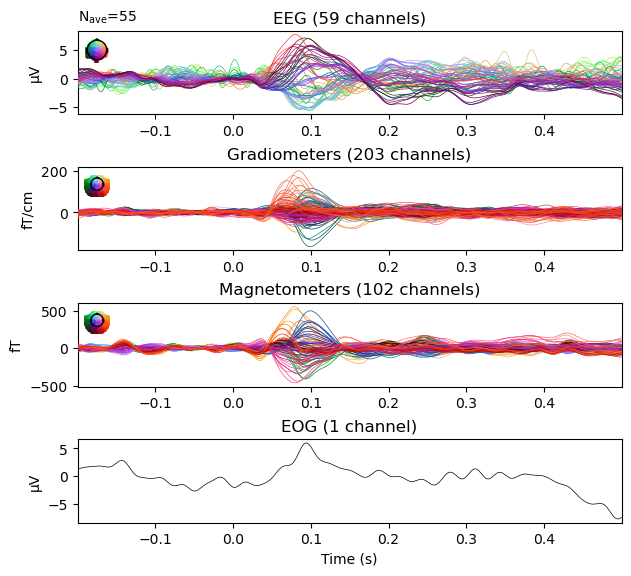

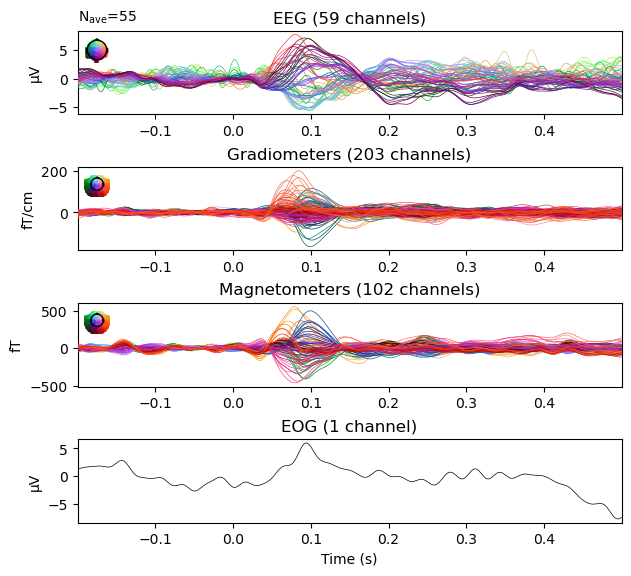

In [11]:
evoked.plot(time_unit='s')

In [5]:
brain = stc.plot(
    initial_time=peak_time, hemi='lh', subjects_dir=subjects_dir,
    smoothing_steps=smoothing_steps)

# You can save a brain movie with:
# brain.save_movie(time_dilation=20, tmin=0.05, tmax=0.16, framerate=10,
#                  interpolation='linear', time_viewer=True)

# stc_max, directions = stc.project('pca', src=inv['src'])
# # These directions must by design be close to the normals because this
# # inverse was computed with loose=0.2
# print('Absolute cosine similarity between source normals and directions: '
#       f'{np.abs(np.sum(directions * inv["source_nn"][2::3], axis=-1)).mean()}')
# brain_max = stc_max.plot(
#     initial_time=peak_time, hemi='lh', subjects_dir=subjects_dir,
#     time_label='Max power', smoothing_steps=smoothing_steps)

Using control points [ 3.95048065  4.56941314 17.72451438]


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 795) to (800, 800) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


#### How do I extract the evoked response from the raw data

In [1]:
import pandas as pd
import numpy as np
import mne
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf

In [2]:
# load data

# i get the data from here: # https://mne.tools/dev/auto_tutorials/simulation/10_array_objs.html

use_precomputed = True


data_path = bst_auditory.data_path()

subject = 'bst_auditory'
subjects_dir = data_path / 'subjects'

raw_fname1 = data_path / 'MEG' / subject / 'S01_AEF_20131218_01.ds'
raw_fname2 = data_path / 'MEG' / subject / 'S01_AEF_20131218_02.ds'
erm_fname = data_path / 'MEG' / subject / 'S01_Noise_20131218_01.ds'



raw = read_raw_ctf(raw_fname1)
n_times_run1 = raw.n_times

# Here we ignore that these have different device<->head transforms
mne.io.concatenate_raws(
    [raw, read_raw_ctf(raw_fname2)], on_mismatch='ignore')
raw_erm = read_raw_ctf(erm_fname)

raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog', 'ECG': 'ecg'})
if not use_precomputed:
    raw.pick(['meg', 'stim', 'misc', 'eog', 'ecg']).load_data()
    
annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1, 2]:
    csv_fname = data_path / 'MEG' / 'bst_auditory' / f'events_bad_0{idx}.csv'
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

saccades_events = df[df['label'] == 'saccade'].values[:, :3].astype(int)

# Conversion from samples to times:
onsets = annotations_df['onset'].values / raw.info['sfreq']
durations = annotations_df['duration'].values / raw.info['sfreq']
descriptions = annotations_df['label'].values


annotations = mne.Annotations(onsets, durations, descriptions)
raw.set_annotations(annotations)
del onsets, durations, descriptions


print('Annotations:', raw.get_data('meg').shape)
# print('Annotations:', raw.get_data('eeg').shape)



# Set the parameters for epoching
tmin, tmax = -0.2, 0.5  # Time window around the event onset

'''Baseline correction aims to remove the baseline level of the signals, 
which can be affected by various sources of noise and physiological 
artifacts, and to normalize the signals across trials or subjects. 
This can improve the sensitivity and specificity of subsequent analyses, 
such as event-related potential (ERP) or event-related field (ERF) 
analysis, time-frequency analysis, or source localization.

Different baseline correction methods are available in MNE-Python:

        Mean subtraction 'mean'
        Median subtraction 'median'
        Z-score normalization 'zscore'
        Deviation correction

    do not apply baseline correction (None, 0)
'''
baseline = (None ,0) # Baseline correction
# baseline_mode = 'zscore' # Baseline correction

# Define the events based on the stimulus triggers
events = mne.find_events(raw)

ds directory : /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26    0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26    0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00    0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    5 extra points added to Polhemus data.
    Measurement info composed.
Finding samples for /home/rickbook/m

In [6]:
raw.get_data('meg').shape
# raw.get_data('eeg').shape

# events

(300, 1728000)

In [51]:
raw.plot()

Channels marked as bad:
none


In [4]:
# Create the epochs object
# epochs by segmenting the continuous data into time-locked
epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=baseline,preload=True)
event_id = epochs.event_id
# dropped 15 epochs because of badly conditioned 

Not setting metadata
560 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 560 events and 1681 original time points ...
15 bad epochs dropped


In [59]:
evoked = epochs.average()

In [44]:
raw.get_data().shape

(340, 1728000)

In [57]:
# events and epochs
epochs.get_data().shape

(545, 340, 1681)

In [58]:
# number of events
print(events.shape)
events # location in the raw, 0, event id

(560, 3)


array([[  13489,       0,      64],
       [  13595,       0,       1],
       [  16929,       0,       1],
       ...,
       [1636847,       0,       1],
       [1640308,       0,       1],
       [1643445,       0,       1]])

Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


/tmp/ipykernel_428/2941739190.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked.plot()


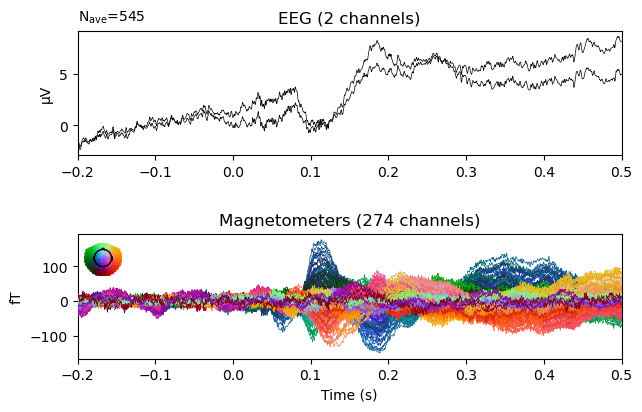

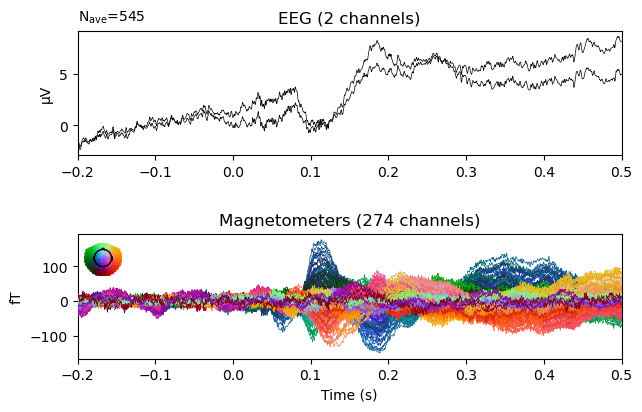

In [60]:
# Plot the evoked responses
evoked.plot()

In [45]:
raw

<RawCTF | S01_AEF_20131218_01.meg4, 340 x 1728000 (720.0 s), ~681 kB, data not loaded>

#### Removing artifacts from raw MEG/EEG data

Artifacts can arise from various sources, including eye blinks, muscle activity, electrical noise, and environmental interference.

There are several methods for removing artifacts from raw MEG/EEG data:

+ Independent component analysis (ICA): decompose the signal in indipendent components, and capture the artifacts by their properties.
+ Template subtraction
+ Regression-based methods

In [32]:
# preprocess bad channels   
# replaces the data from the bad channels with interpolated values based on the surrounding channels
# raw.info['bads']
# mne.channels.interpolation.interpolate_bads(raw, reset_bads=True)

[]

In [5]:
# Set the parameters for ICA
# n_components = 276  # Number of components to decompose
# method = 'fastica'  # ICA method

# # Define the ICA object
# ica = mne.preprocessing.ICA(n_components=n_components, method=method)

# # Fit the ICA object to the data
# ica.fit(raw)
# ica.apply(raw)

1793

#### Get the stimulus response from each epoch


In [46]:
# epochs.ch_names.index('STI 0013')

# epochs.plot()

""" Metrics for MEG/EEG data GFP
GFP stands for Global Field Power, which is a measure of the overall strength or 
variability of the MEG/EEG signals across all sensors or channels. It is calculated 
by computing the root mean square (RMS) of the signals across all sensors or 
channels, at each time point.

The GFP is a useful measure for characterizing the temporal dynamics and spatial 
distribution of the MEG/EEG signals, as it provides a single value that reflects 
both the amplitude and coherence of the signals across different sensors or channels.

"""
""" What are EOG projectors?

    EOG (Electrooculography) projectors for magnetometers are spatial filters that 
    are used to reduce the influence of eye movements and blinks on the MEG signals 
    recorded by magnetometers. EOG projectors are typically applied as a preprocessing 
    step, before source estimation or connectivity analysis.

    The basic idea behind EOG projectors is to estimate the spatial pattern of the 
    EOG signals based on the difference between the signals recorded at pairs of EOG 
    electrodes placed around the eyes, and then project this pattern onto the MEG sensors 
    using a linear transformation matrix. The resulting "virtual channels" represent a 
    weighted combination of the original MEG signals that are maximally correlated with 
the EOG signals, and minimize the contribution of the EOG artifacts to the data.

"""

' What are EOG projectors?\n\n    EOG (Electrooculography) projectors for magnetometers are spatial filters that \n    are used to reduce the influence of eye movements and blinks on the MEG signals \n    recorded by magnetometers. EOG projectors are typically applied as a preprocessing \n    step, before source estimation or connectivity analysis.\n\n    The basic idea behind EOG projectors is to estimate the spatial pattern of the \n    EOG signals based on the difference between the signals recorded at pairs of EOG \n    electrodes placed around the eyes, and then project this pattern onto the MEG sensors \n    using a linear transformation matrix. The resulting "virtual channels" represent a \n    weighted combination of the original MEG signals that are maximally correlated with \nthe EOG signals, and minimize the contribution of the EOG artifacts to the data.\n\n'

In [36]:
epochs

# the stimuli channel are those one UPPT001

Number of events,545
Events,1: 3872: 8064: 78
Time range,-0.200 – 0.500 sec
Baseline,-0.200 – 0.000 sec


In [37]:
epochs['1'].get_data().shape


(387, 340, 1681)

In [38]:
epochs['2'].get_data().shape

(80, 340, 1681)

In [39]:
epochs['64'].get_data().shape

(78, 340, 1681)

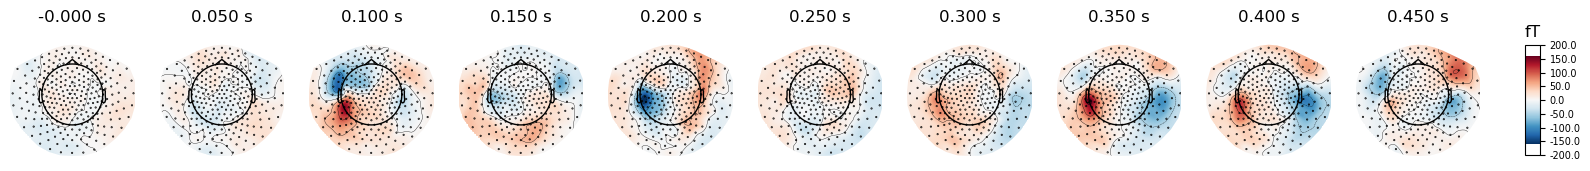

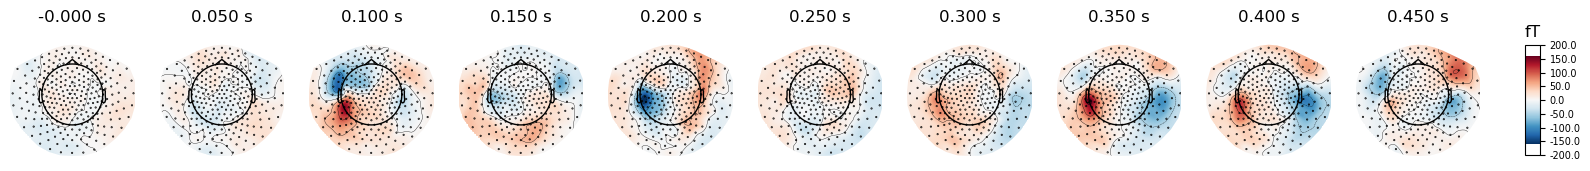

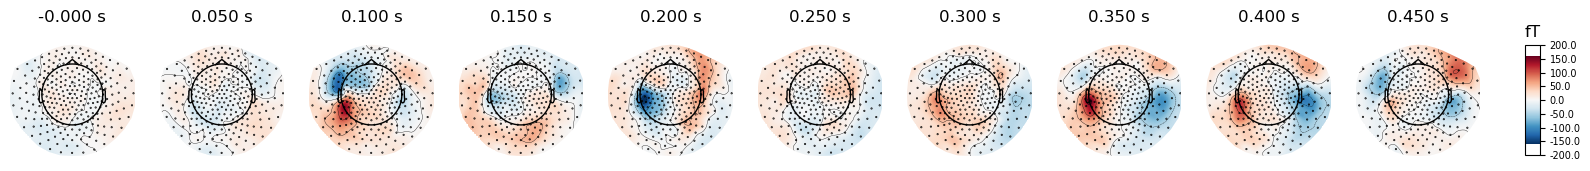

In [33]:
times = np.arange(-0.0, 0.5, 0.05)

evoked_std = epochs['1'].average()
evoked_dev = epochs['1'].average()

# plot the evoked responses as topographcs maps
evoked_std.plot_topomap(times=times)
evoked_dev.plot_topomap(times=times)

In [35]:
tmin, tmax = -0.1, 0.5
event_id = dict(standard=1, deviant=2)
reject = dict(mag=4e-12, eog=250e-6)
# find events
events = mne.find_events(raw, stim_channel='UPPT001')

480 events found
Event IDs: [1 2]


In [36]:
sound_data = raw[raw.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) > 2. * np.std(sound_data))[0]
min_diff = int(0.5 * raw.info['sfreq'])
diffs = np.concatenate([[min_diff + 1], np.diff(onsets)])
onsets = onsets[diffs > min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))
events[:, 0] = onsets
del sound_data, diffs

Trigger delay removed (μ ± σ): -14.0 ± 0.3 ms


In [54]:
events[:, 0].shape # the stimulus

(480,)

In [55]:
raw.plot()

Channels marked as bad:
none


In [38]:
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=['meg', 'eog'],
                    baseline=(None, 0), reject=reject, preload=False,
                    proj=True)

Not setting metadata
480 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


In [40]:
print(epochs.event_id)

epochs.get_data().shape

{'standard': 1, 'deviant': 2}
Loading data for 480 events and 1441 original time points ...
    Rejecting  epoch based on MAG : ['MLF14-4408', 'MLT21-4408', 'MLT31-4408', 'MLT32-4408', 'MLT41-4408', 'MLT42-4408', 'MLT51-4408', 'MRF14-4408', 'MRT31-4408', 'MRT41-4408']
    Rejecting  epoch based on MAG : ['MLF14-4408', 'MLT21-4408', 'MLT31-4408', 'MLT32-4408', 'MLT41-4408', 'MLT51-4408', 'MRT31-4408', 'MRT41-4408']
    Rejecting  epoch based on MAG : ['MLF14-4408', 'MLT21-4408', 'MLT31-4408', 'MLT32-4408', 'MLT41-4408', 'MLT42-4408', 'MLT51-4408', 'MRF14-4408', 'MRT31-4408', 'MRT32-4408', 'MRT41-4408', 'MRT51-4408']
    Rejecting  epoch based on MAG : ['MLF14-4408', 'MLT21-4408', 'MLT31-4408', 'MLT32-4408', 'MLT41-4408', 'MLT42-4408', 'MLT51-4408', 'MRF14-4408', 'MRT31-4408', 'MRT41-4408']
    Rejecting  epoch based on MAG : ['MLP52-4408']
    Rejecting  epoch based on MAG : ['MLF14-4408', 'MLT21-4408', 'MLT31-4408', 'MLT32-4408', 'MLT41-4408', 'MLT42-4408', 'MLT51-4408', 'MRF14-4408', 

(437, 302, 1441)

In [41]:
epochs.drop_bad()

# avoid warning about concatenating with annotations
epochs.set_annotations(None)

epochs_standard = mne.concatenate_epochs([epochs['standard'][range(40)],
                                          epochs['standard'][182:222]])
epochs_standard.load_data()  # Resampling to save memory.
epochs_standard.resample(600, npad='auto')
epochs_deviant = epochs['deviant'].load_data()
epochs_deviant.resample(600, npad='auto')
del epochs

Loading data for 40 events and 1441 original time points ...
Loading data for 40 events and 1441 original time points ...
Not setting metadata
80 matching events found
Applying baseline correction (mode: mean)
Loading data for 74 events and 1441 original time points ...


In [42]:
evoked_std = epochs_standard.average()
evoked_dev = epochs_deviant.average()
del epochs_standard, epochs_deviant



In [56]:
"""
    to remove high-frequency noise and artifacts that are not relevant for the analysis 
    of the neural signals. The choice of 40 Hz as the cutoff frequency is based on the 
    fact that most of the relevant frequency components of the EEG and MEG signals are 
    below this frequency, especially for resting-state or task-related brain activity.
"""

for evoked in (evoked_std, evoked_dev):
    evoked.filter(l_freq=None, h_freq=40., fir_design='firwin')

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.332 sec)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 199 samples (0.332 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [44]:
subject = 'bst_auditory'
subjects_dir = data_path / 'subjects'

# https://mne.tools/stable/auto_tutorials/io/60_ctf_bst_auditory.html#sphx-glr-auto-tutorials-io-60-ctf-bst-auditory-py

src = mne.setup_source_space(subject, spacing='oct6', add_dist=False, subjects_dir=subjects_dir)

# boundary element model (BEM) compute the conductivity of the head tissues 
conductivity = [0.3]  # scalp, skull, brain conductivity values
model = mne.make_bem_model(subject, subjects_dir=subjects_dir, conductivity=conductivity, ico=4)
bem = mne.make_bem_solution(model)

# Set montage
# montage = 'standard_1020'
# epochs.set_montage(mne.channels.make_standard_montage(montage))

# Compute the forward solution
# using the BEM map the source activity of the sensors
# fwd = mne.make_forward_solution(epochs.info, trans=None, src=src, bem=bem, meg=True, eeg=True,mindist=5.0, n_jobs=1)

# evoked_std = epochs['1'].average()

trans_fname = data_path / 'MEG' / 'bst_auditory' / 'bst_auditory-trans.fif'
trans = mne.read_trans(trans_fname)

fwd = mne.make_forward_solution(evoked_std.info, trans=trans, src=src,bem=bem)

'''
    raw_erm is a term commonly used in MNE-Python to refer to a "empty-room" 
    recording, which is a type of recording used to estimate the noise covariance 
    matrix for MEG and EEG data. The empty-room recording is typically obtained 
    with no subject present in the MEG or EEG system, and is used to estimate 
    the background noise level and the spatial covariance of the noise in the 
    sensors.

'''

reject = dict(mag=4e-12)
cov = mne.compute_raw_covariance(raw_erm, reject=reject)

inv = mne.minimum_norm.make_inverse_operator(evoked_std.info, fwd, cov)
del fwd

Setting up the source space with the following parameters:

SUBJECTS_DIR = /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/subjects
Subject      = bst_auditory
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/subjects/bst_auditory/surf/lh.white...
Mapping lh bst_auditory -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/subjects/bst_auditory/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/163080 selected to source space (oct = 6)

Loading /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/subjects/bst_auditory/surf/rh.white...
Mapping rh bst_auditory -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /home/rickbook/mne_data/MNE-brainstorm-data/bst_auditory/subjec

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2907 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2698.7 ms
Checking surface interior status for 4098 points...
    Found 1176/4098 points inside  an interior sphere of radius   49.5 mm
    Found    0/4098 points outside an exterior sphere of radius  105.1 mm
    Found    0/2922 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found    0/2922 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 2698.4 ms

Checking surface interior status for 300 points...
    Found   0/300 points inside  an interior sphere of radius   49.5 mm
    Found 300/300 points outside an exterior sphere of radius  105.1 mm
    Found   0/  0 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found   0/  0 points outside using solid angles
    Total 0/300 points inside the surface
Interior check completed in 275.3 ms

Composing the field computation matrix...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Computing MEG at 8196 source locations (free orientations)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished



Finished.
Using up to 150 segments
Number of samples used : 72000
[done]
Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 274 channels.
    274 out of 274 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 274 channels
Creating the depth weighting matrix...
    274 magnetometer or axial gradiometer channels
    limit = 8028/8196 = 10.035150
    scale = 6.30499e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 1.7e-14 (2.2e-16 eps * 274 dim * 0.27  max singular value)
    Estim

In [64]:
data = evoked.get_data()

data = data[:, 1:] - data[:, :-1]

evoked = mne.EvokedArray(data, evoked.info, tmin=evoked.times[0])

In [65]:
import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, apply_inverse


# Apply inverse solution, set pick_ori='vector' to obtain a
# :class:`mne.VectorSourceEstimate` object
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(evoked, inv, lambda2, 'dSPM', pick_ori='vector')

# Use peak getter to move visualization to the time point of the peak magnitude
_, peak_time = stc.magnitude().get_peak(hemi='lh')

Removing 5 compensators from info because not all compensation channels were picked.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 274 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 274 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  91.6% variance
    dSPM...
[done]


In [66]:
smoothing_steps = 7

brain = stc.plot(
    initial_time=peak_time, hemi='lh', subjects_dir=subjects_dir,
    smoothing_steps=smoothing_steps)

# You can save a brain movie with:
# brain.save_movie(time_dilation=20, tmin=0.05, tmax=0.16, framerate=10,
#                  interpolation='linear', time_viewer=True)

Using control points [0.08262457 0.09484115 0.21072492]


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.datasets import multimodal
from mne.io import read_raw_ctf

# multimodal_raw
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
print(raw.info['bads'])

# Set the parameters for epoching
tmin, tmax = -0.1, 0.5  # Time window around the event onset

baseline = (None ,0) # Baseline correction
# baseline_mode = 'zscore' # Baseline correction

# Find the stim channel
stim_channel = mne.pick_types(raw.info, meg=False, stim=True)

print(stim_channel)


# Define the events based on the stimulus triggers
events = mne.find_events(raw, shortest_event=1, verbose=True)

# Create the epochs object
# epochs by segmenting the continuous data into time-locked

reject = dict(mag=4e-12, eog=250e-6)
event_id = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '8': 8, '16': 16, '32': 32}

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=['meg', 'eog'],
                    baseline=baseline, reject=reject, preload=False,
                    proj=True)

event_id = epochs.event_id


"""Resampling

    Resampling can be useful for a variety of reasons, such as
    reducing the computational load, aligning data from different 
    sources, or preparing the data for a specific analysis.

    The resample function in MNE-Python has the following syntax:

    new_raw = raw.resample(sfreq_new, npad='auto')

"""


epochs.drop_bad()

epochs.set_annotations(None)

epochs_resampled = epochs['8'].copy()
epochs_resampled.load_data()
epochs_resampled.resample(600, npad='auto')

evoked_std = epochs_resampled.average()


"""
    to remove high-frequency noise and artifacts that are not relevant for the analysis 
    of the neural signals. The choice of 40 Hz as the cutoff frequency is based on the 
    fact that most of the relevant frequency components of the EEG and MEG signals are 
    below this frequency, especially for resting-state or task-related brain activity.
"""

evoked_std.filter(l_freq=None, h_freq=40., fir_design='firwin')



Opening raw data file /home/rickbook/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
[]
[306 307 308 309 310 311 312 313 314]
942 events found
Event IDs: [ 1  2  3  4  5  8 16 32]
Not setting metadata
942 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Loading data for 942 events and 361 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    0.1s finished


<Evoked | '8' (average, N=107), -0.099898 – 0.5001 sec, baseline -0.0998976 – 0 sec, 306 ch, ~4.2 MB>

In [77]:
evoked_std.get_data().shape

(306, 361)

In [78]:
import numpy as np
import mne
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, apply_inverse


data = evoked_std.get_data()[:300,:359]

evoked_copy = mne.EvokedArray(data, evoked.info, tmin=evoked.times[0])

# Apply inverse solution, set pick_ori='vector' to obtain a
# :class:`mne.VectorSourceEstimate` object
snr = 3.0
lambda2 = 1.0 / snr ** 2
stc = apply_inverse(evoked_copy, inv, lambda2, 'dSPM', pick_ori='vector')

# Use peak getter to move visualization to the time point of the peak magnitude
_, peak_time = stc.magnitude().get_peak(hemi='lh')

Removing 5 compensators from info because not all compensation channels were picked.
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 274 (0 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to ""...
    Picked 274 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  17.2% variance
    dSPM...
[done]


In [79]:
smoothing_steps = 7

brain = stc.plot(
    initial_time=peak_time, hemi='lh', subjects_dir=subjects_dir,
    smoothing_steps=smoothing_steps)

# You can save a brain movie with:
# brain.save_movie(time_dilation=20, tmin=0.05, tmax=0.16, framerate=10,
#                  interpolation='linear', time_viewer=True)

Using control points [27.57795703 31.83359623 65.23444338]


### Sample dataset 

There are many datasets available in MNE. Here we use the sample dataset, which is a small MEG/EEG dataset that is used for testing and demonstration purposes. The dataset consists of 60 subjects performing an audiovisual experiment, along with structural MRI scans for each subject. For each subject, there are three separate experimental runs, resulting in a total of 180 files to be processed. The data are available on the MNE website at https://mne.tools/stable/manual/sample_dataset.html.

In [1]:
import mne

data_path = mne.datasets.sample.data_path()

subject = 'MNE-sample-data'
subjects_dir = data_path / 'subjects'

In [2]:
raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
# erm_fname = data_path / 'MEG' / subject / 'S01_Noise_20131218_01.ds'
erm_fname = data_path / 'MEG' / 'sample' / 'ernoise_raw.fif'


raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw_erm = mne.io.read_raw_fif(erm_fname, preload=True)

Opening raw data file /home/rickbook/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Opening raw data file /home/rickbook/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Reading 0 ... 66067  =      0.000 ...   109.999 secs...


In [11]:
!ls /home/rickbook/mne_data/MNE-sample-data/MEG/sample | grep -i raw


ernoise_raw-eve.fif
ernoise_raw.fif
sample_audvis_filt-0-40_raw-eve.fif
sample_audvis_filt-0-40_raw.fif
sample_audvis_raw-eve.fif
sample_audvis_raw-trans.fif
sample_audvis_raw.fif


In [15]:
raw

<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MB, data loaded>

In [3]:
use_precomputed = True

raw.set_channel_types({'EOG 061': 'eog'})

if not use_precomputed:
    raw.pick(['meg', 'stim', 'misc', 'eog', 'ecg']).load_data()

print('Annotations:', raw.get_data('meg').shape)
print('Annotations:', raw.get_data('eeg').shape)

Annotations: (306, 41700)
Annotations: (60, 41700)


In [4]:
# Create the epochs object
# epochs by segmenting the continuous data into time-locked

"""Name

    Contents

        LA 1 Response to left-ear auditory stimulus 

        RA 2 Response to right-ear auditory stimulus

        LV 3 Response to left visual field stimulus

        RV 4 Response to right visual field stimulus

        smiley 5 Response to the smiley face button 
        
        32  Response triggered by the button press

"""

tmin, tmax = -0.1, 0.5  # Time window around the event onset    

events = mne.find_events(raw)
baseline = (None ,0) # Baseline correction


epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=baseline,preload=True)
event_id = epochs.event_id

319 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
319 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 319 events and 91 original time points ...
0 bad epochs dropped


In [41]:
print(event_id)

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '32': 32}


In [42]:
evoked = epochs['5'].average()


# apply a low-pass filter to the data
evoked.filter(l_freq=None, h_freq=40., fir_design='firwin')

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 51 samples (0.340 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 364 out of 364 | elapsed:    0.1s finished


<Evoked | '5' (average, N=15), -0.099898 – 0.49949 sec, baseline -0.0998976 – 0 sec, 364 ch, ~3.5 MB>

In [43]:
evoked.get_data().shape

(364, 91)

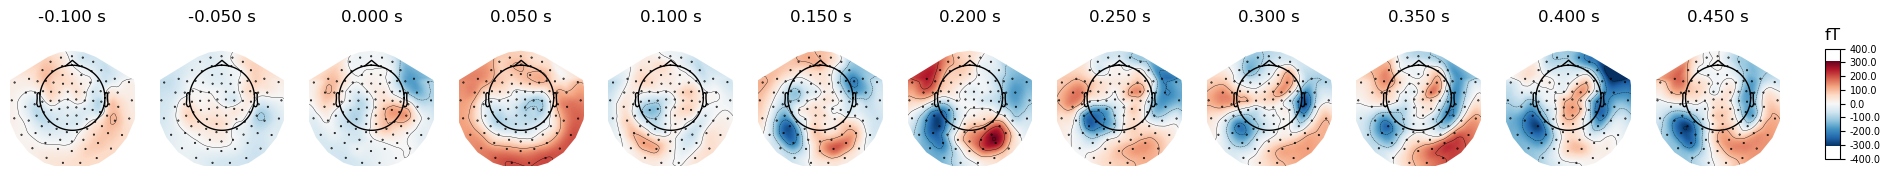

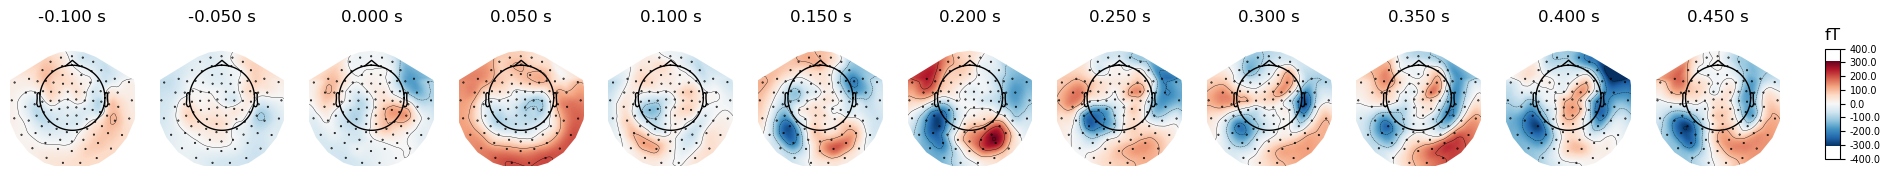

In [45]:
import numpy as np

times = np.arange(tmin, tmax, 0.05)

# plot the evoked responses as topographcs maps
evoked.plot_topomap(times=times)

Using up to 550 segments
Number of samples used : 66000
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.7e-13 (2.2e-16 eps * 102 dim * 12  max singular value)
    Estimated rank (mag): 102
    MAG: rank 102 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


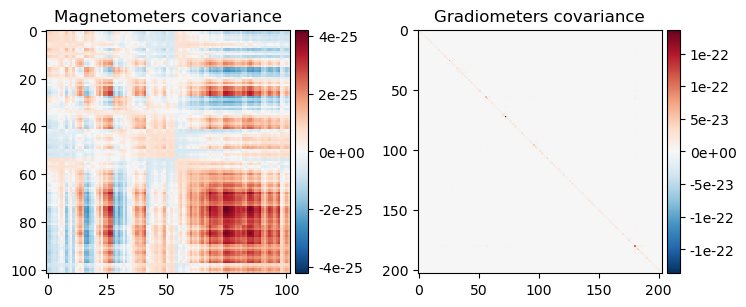

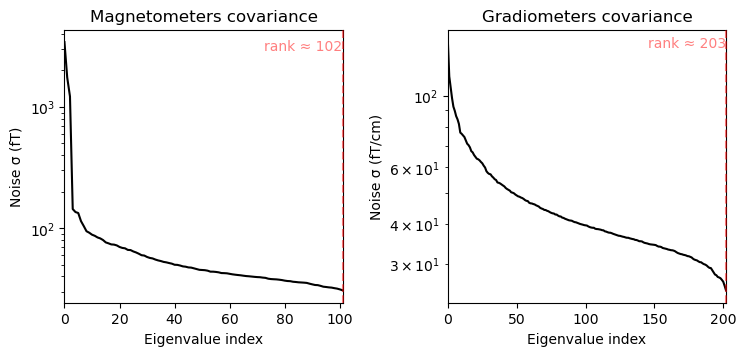

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [46]:
reject = dict(mag=4e-12)
cov = mne.compute_raw_covariance(raw_erm, reject=reject)
cov.plot(raw_erm.info)

In [47]:
!ls /home/rickbook/mne_data/MNE-sample-data/MEG/sample | grep -i fwd

sample_audvis-eeg-oct-6-fwd-sensmap-4-lh.w
sample_audvis-eeg-oct-6-fwd-sensmap-4-rh.w
sample_audvis-eeg-oct-6-fwd-sensmap-5-lh.w
sample_audvis-eeg-oct-6-fwd-sensmap-5-rh.w
sample_audvis-eeg-oct-6-fwd-sensmap-6-lh.w
sample_audvis-eeg-oct-6-fwd-sensmap-6-rh.w
sample_audvis-eeg-oct-6-fwd-sensmap-7-lh.w
sample_audvis-eeg-oct-6-fwd-sensmap-7-rh.w
sample_audvis-eeg-oct-6-fwd-sensmap-lh.w
sample_audvis-eeg-oct-6-fwd-sensmap-rh.w
sample_audvis-eeg-oct-6-fwd.fif
sample_audvis-eeg-oct-6p-fwd.fif
sample_audvis-grad-oct-6-fwd-sensmap-2-lh.w
sample_audvis-grad-oct-6-fwd-sensmap-2-rh.w
sample_audvis-grad-oct-6-fwd-sensmap-lh.w
sample_audvis-grad-oct-6-fwd-sensmap-rh.w
sample_audvis-grad-vol-7-fwd-sensmap-vol.w
sample_audvis-mag-oct-6-fwd-sensmap-3-lh.w
sample_audvis-mag-oct-6-fwd-sensmap-3-rh.w
sample_audvis-mag-oct-6-fwd-sensmap-lh.w
sample_audvis-mag-oct-6-fwd-sensmap-rh.w
sample_audvis-meg-eeg-oct-6-fwd.fif
sample_audvis-meg-oct-6-fwd-sensmap-lh.w
sample_audvis-meg-oct-6-fwd-sensmap-rh.w
sample_a

In [57]:
if use_precomputed:
    fwd_fname = (
        data_path / 'MEG' / 'sample' / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
    )
    fwd = mne.read_forward_solution(fwd_fname)

Reading forward solution from /home/rickbook/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


In [58]:
inv = mne.minimum_norm.make_inverse_operator(evoked.info, fwd, cov)
snr = 3.0
lambda2 = 1.0 / snr ** 2
del fwd

stc = mne.minimum_norm.apply_inverse(evoked, inv, lambda2, 'dSPM', pick_ori='vector')

# Use peak getter to move visualization to the time point of the peak magnitude
_, peak_time = stc.magnitude().get_peak(hemi='lh')

smoothing_steps = 7


""" IMPORTANT

    when you are looking the simulation of the brain activity
    discuss which part of the brain are involved in the activity

    looking at the brain activity could help you to understand and 
    have insights about what the brain is processing


"""
brain = stc.plot(
    initial_time=peak_time, hemi='lh', subjects_dir=subjects_dir,
    smoothing_steps=smoothing_steps)

# You can save a brain movie with:
# brain.save_movie(time_dilation=20, tmin=0.05, tmax=0.16, framerate=10,
#                  interpolation='linear', time_viewer=True)




Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 305 channels.
    305 out of 366 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 305 dim * 2.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

### How to plot the evoked response in a 2D space

Given the responces I produce the attention maps which express how correlate the signal with the stimulus in the behaviour with other signals from other channels.

In [5]:
"""Name

    Contents

        LA 1 Response to left-ear auditory stimulus 

        RA 2 Response to right-ear auditory stimulus

        LV 3 Response to left visual field stimulus

        RV 4 Response to right visual field stimulus

        smiley 5 Response to the smiley face button 
        
        32  Response triggered by the button press

"""

epochs.filter(l_freq=None, h_freq=40., fir_design='firwin')
epochs

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 51 samples (0.340 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116754 out of 116754 | elapsed:   24.5s finished


Number of events,319
Events,1: 722: 733: 7332: 164: 705: 15
Time range,-0.100 – 0.499 sec
Baseline,-0.100 – 0.000 sec


Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


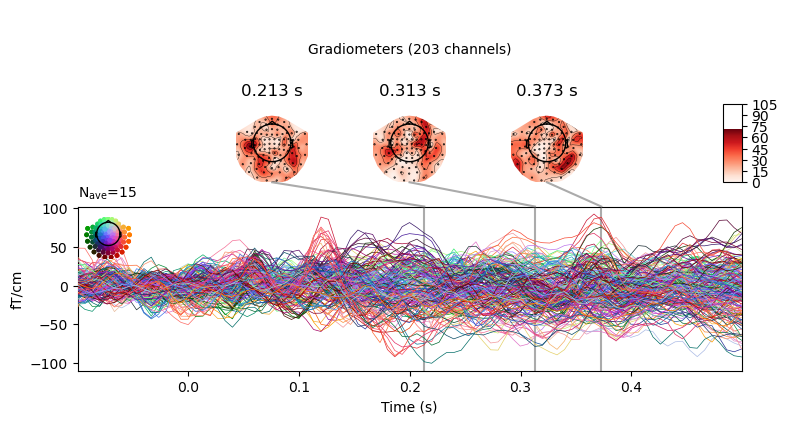

Removing projector <Projection | Average EEG reference, active : True, n_channels : 60>


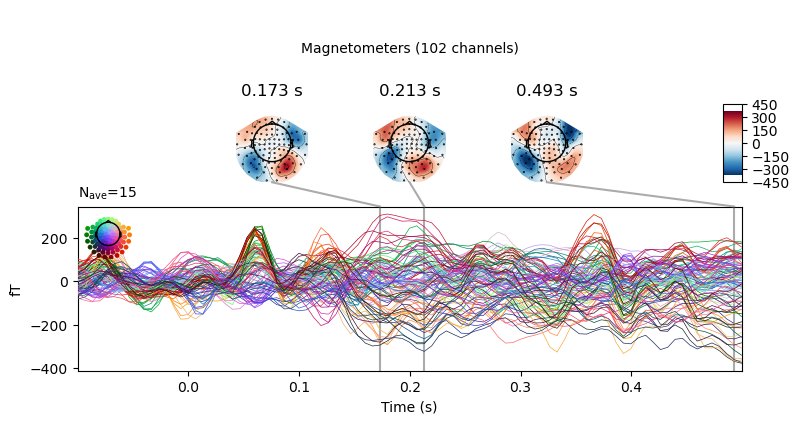

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>


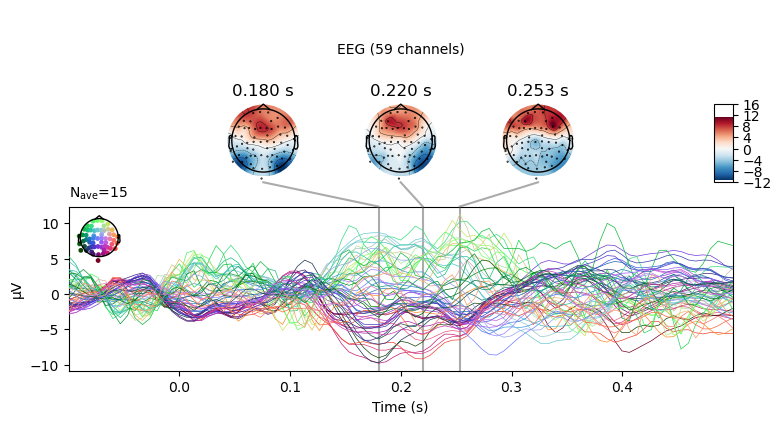

[<Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>,
 <Figure size 800x420 with 7 Axes>]

In [16]:
epochs['5'].average().plot_joint()

In [6]:
data_1 = epochs['1'].average().get_data('eeg')
data_2 = epochs['2'].average().get_data('eeg')
data_3 = epochs['3'].average().get_data('eeg')
data_4 = epochs['4'].average().get_data('eeg')
data_5 = epochs['5'].average().get_data('eeg')
data_32 = epochs['32'].average().get_data('eeg')

In [161]:
data_1 = epochs['1'].get_data('meg')
data_2 = epochs['2'].get_data('meg')
data_3 = epochs['3'].get_data('meg')
data_4 = epochs['4'].get_data('meg')
data_5 = epochs['5'].get_data('meg')
data_32 = epochs['32'].get_data('meg')

In [48]:

import torch

    init = torch.Tensor(data_1[0][0].reshape(91,1))@torch.Tensor(data_1[0][0].reshape(1,91))

    for i in range(1, len(data_1)):

        # dot product signal with itself
        [torch.stack((init,torch.Tensor(data_1[0][i].reshape(91,1))@torch.Tensor(data_1[0][i].reshape(1,91))),dim=0)
         
         for i in range(1, len(data_1))]

    torch.stack((init,torch.Tensor(data_1[0][0].reshape(91,1))@torch.Tensor(data_1[0][0].reshape(1,91))),dim=0).shape



torch.Size([2, 91, 91])

In [55]:
torch.sum(torch.Tensor(data_1[0][0].reshape(91,1))@torch.Tensor(data_1[0][0].reshape(1,91)),dim=0)

tensor([ 9.0134e-10,  2.6317e-09,  1.8965e-09, -2.3354e-09, -4.0632e-09,
         2.9188e-10,  4.6758e-09,  2.9927e-09, -1.7260e-09, -4.2149e-09,
        -4.7639e-09, -4.7050e-09, -2.2685e-09,  2.4320e-09,  5.0839e-09,
         3.3627e-09,  3.9783e-10, -4.5924e-11,  1.9914e-09,  4.3021e-09,
         5.6771e-09,  6.2233e-09,  5.9669e-09,  4.2768e-09,  1.1661e-09,
        -1.1551e-09, -4.1201e-11,  3.5665e-09,  5.7760e-09,  5.6535e-09,
         6.5620e-09,  9.7542e-09,  1.1446e-08,  9.0110e-09,  5.3105e-09,
         3.9108e-09,  4.4549e-09,  5.3907e-09,  6.7881e-09,  7.9219e-09,
         6.3078e-09,  1.8508e-09, -1.3490e-09,  1.1412e-10,  4.4052e-09,
         7.0238e-09,  6.7718e-09,  6.6492e-09,  8.3783e-09,  9.0198e-09,
         5.9049e-09,  2.1353e-09,  2.0281e-09,  3.5493e-09,  2.4425e-09,
         1.4170e-09,  5.5946e-09,  1.0805e-08,  8.4433e-09,  1.1562e-09,
         1.8215e-11,  5.5650e-09,  6.4235e-09, -8.5954e-10, -5.5981e-09,
        -1.0170e-09,  5.1450e-09,  4.3310e-09,  3.0

In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn


In [47]:
def get_embds(data):
    """Generate the maps from the signal

    Args:
        data (list): list of signals
    
    Returns:    
        data_embds (torch.Tensor): list of maps
    
    """
    data_embds = []
    softmax = nn.Softmax(dim=1)

    # generate the maps from the signal
    # for i in range(0, len(data)):
    #     # dot product signal with itself
    #     data_embds.append([
    #             torch.Tensor(data[i][j].reshape(data[0][0].shape[0], 1))@torch.Tensor(data[i][j].reshape(1, data[0][0].shape[0])) 
    #                                 for j in range(0, len(data[i]))
    #             ])
    # for idx, i in enumerate(data_embds):
    #     for idy, j in enumerate(i):
    #         data_embds_tensor[idx][idy] = torch.sum(j)**2 # torch.linalg.eigvals(j) # (torch.sum(j)-torch.mean(j))/torch.std(j)


    # dot product signal with itself
    data_embds = [
            torch.Tensor(softmax(torch.Tensor(data[j].reshape(data[0].shape[0], 1))@torch.Tensor(data[j].reshape(1, data[0].shape[0])))@torch.Tensor(data[j].reshape(data[0].shape[0], 1)))
                                for j in range(0, len(data))
            ]

    # data_embds_tensor = torch.zeros(len(data_embds),len(data_embds[0]),data[0][0].shape[0],data[0][0].shape[0])
    # data_embds_tensor = torch.zeros(len(data_embds),len(data_embds[0]),data[0][0].shape[0])
    data_embds_tensor = torch.zeros(len(data_embds),len(data_embds[0]))
    data_embds_tensor = torch.zeros(len(data_embds),data[0].shape[0])
    # data_embds_tensor = torch.zeros(len(data_embds),len(data_embds[0]),data_embds[0][0].shape[0]*data_embds[0][0].shape[0])

    
    for idx, i in enumerate(data_embds):
        data_embds_tensor[idx] = torch.mean(i,dim=0) # torch.linalg.eigvals(j) # (torch.sum(j)-torch.mean(j))/torch.std(j)

    print('shape: ',data_embds_tensor.shape)

    return data_embds_tensor

# Create the epochs object
# epochs by segmenting the continuous data into time-locked

"""Name

    Contents

        LA 1 Response to left-ear auditory stimulus 

        RA 2 Response to right-ear auditory stimulus

        LV 3 Response to left visual field stimulus

        RV 4 Response to right visual field stimulus

        smiley 5 Response to the smiley face button 
        
        32  Response triggered by the button press

"""

import mne

data_path = mne.datasets.sample.data_path()

subject = 'MNE-sample-data'
subjects_dir = data_path / 'subjects'

raw_fname = data_path / 'MEG' / 'sample' / 'sample_audvis_filt-0-40_raw.fif'
# erm_fname = data_path / 'MEG' / subject / 'S01_Noise_20131218_01.ds'
erm_fname = data_path / 'MEG' / 'sample' / 'ernoise_raw.fif'


raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw_erm = mne.io.read_raw_fif(erm_fname, preload=True)

tmin, tmax = -0.1, 0.5  # Time window around the event onset    

events = mne.find_events(raw)
baseline = (None ,0) # Baseline correction


epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmax, baseline=baseline,preload=True)
event_id = epochs.event_id


data_1 = epochs['1'].get_data()
data_2 = epochs['2'].get_data()
data_3 = epochs['3'].get_data()
data_4 = epochs['4'].get_data()
data_5 = epochs['5'].get_data()



data_1_embds = get_embds(data_1)
data_2_embds = get_embds(data_2)
data_3_embds = get_embds(data_3)
data_4_embds = get_embds(data_4)
data_5_embds = get_embds(data_5)
data_32_embds = get_embds(data_32)


emb = torch.cat((data_1_embds, 
                 data_2_embds, 
                 data_3_embds,
                 data_4_embds,
                 data_5_embds,
                 data_32_embds
                ), dim=0)


# emb = torch.cat((data_1_embds[:,0,:].reshape(72,91), 
#                  data_2_embds[:,0,:].reshape(73,91), 
#                  data_3_embds[:,0,:].reshape(73,91),
#                  data_4_embds[:,0,:].reshape(70,91),
#                  data_5_embds[:,0,:].reshape(15,91),
#                  data_32_embds[:,0,:].reshape(16,91),
                 
#                 ), dim=0)

Opening raw data file /home/rickbook/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Opening raw data file /home/rickbook/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Reading 0 ... 66067  =      0.000 ...   109.999 secs...
319 events found
Event IDs: [ 1  2  3  4  5 32]
Not setting metadata
319 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (sub

In [29]:
data_1 = epochs['1'].average().get_data()
data_2 = epochs['2'].average().get_data()
data_3 = epochs['3'].average().get_data()
data_4 = epochs['4'].average().get_data()
data_5 = epochs['5'].average().get_data()
data_32 = epochs['32'].average().get_data()

data_1_embds = torch.Tensor(np.sum(data_1, axis=0).reshape(1, 91))
data_2_embds = torch.Tensor(np.sum(data_2, axis=0).reshape(1, 91))
data_3_embds = torch.Tensor(np.sum(data_3, axis=0).reshape(1, 91))
data_4_embds = torch.Tensor(np.sum(data_4, axis=0).reshape(1, 91))
data_5_embds = torch.Tensor(np.sum(data_5, axis=0).reshape(1, 91))
data_32_embds = torch.Tensor(np.sum(data_32, axis=0).reshape(1, 91))

emb = torch.cat((data_1_embds, 
                 data_2_embds, 
                 data_3_embds,
                 data_4_embds,
                 data_5_embds,
                 data_32_embds
                ), dim=0)


emb = (emb - torch.min(emb))/(torch.max(emb) - torch.min(emb))

epochs

Number of events,319
Events,1: 722: 733: 7332: 164: 705: 15
Time range,-0.100 – 0.499 sec
Baseline,-0.100 – 0.000 sec


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.datasets import multimodal
from mne.io import read_raw_ctf

# multimodal_raw
fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)
print(raw.info['bads'])

# Set the parameters for epoching
tmin, tmax = -0.1, 0.5  # Time window around the event onset

baseline = (None ,0) # Baseline correction
# baseline_mode = 'zscore' # Baseline correction

# Find the stim channel
stim_channel = mne.pick_types(raw.info, meg=False, stim=True)

print(stim_channel)


# Define the events based on the stimulus triggers
events = mne.find_events(raw, shortest_event=1, verbose=True)

# Create the epochs object
# epochs by segmenting the continuous data into time-locked

reject = dict(mag=4e-12, eog=250e-6)
event_id = {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '8': 8, '16': 16, '32': 32}

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=['meg', 'eog'],
                    baseline=baseline, reject=reject, preload=False,
                    proj=True)

event_id = epochs.event_id


"""Resampling

    Resampling can be useful for a variety of reasons, such as
    reducing the computational load, aligning data from different 
    sources, or preparing the data for a specific analysis.

    The resample function in MNE-Python has the following syntax:

    new_raw = raw.resample(sfreq_new, npad='auto')

"""


epochs.drop_bad()

epochs.set_annotations(None)

Opening raw data file /home/rickbook/mne_data/MNE-multimodal-data/multimodal_raw.fif...
    Read a total of 7 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
    Range : 183600 ... 576599 =    305.687 ...   960.014 secs
Ready.
[]
[306 307 308 309 310 311 312 313 314]
942 events found
Event IDs: [ 1  2  3  4  5  8 16 32]
Not setting metadata
942 matching events found
Setting baseline interval to [-0.09989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 7)
7 projection items activated
Loading data for 942 events and 361 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061'

Number of events,654
Events,1: 10016: 02: 1053: 8632: 834: 895: 848: 107
Time range,-0.100 – 0.499 sec
Baseline,-0.100 – 0.000 sec


In [33]:
data_1 = epochs['1'].average().get_data()
data_2 = epochs['2'].average().get_data()
data_3 = epochs['3'].average().get_data()
data_4 = epochs['4'].average().get_data()
data_5 = epochs['5'].average().get_data()
# data_32 = epochs['32'].average().get_data()

data_1_embds = torch.Tensor(np.sum(data_1, axis=0).reshape(1, 361))
data_2_embds = torch.Tensor(np.sum(data_2, axis=0).reshape(1, 361))
data_3_embds = torch.Tensor(np.sum(data_3, axis=0).reshape(1, 361))
data_4_embds = torch.Tensor(np.sum(data_4, axis=0).reshape(1, 361))
data_5_embds = torch.Tensor(np.sum(data_5, axis=0).reshape(1, 361))
# data_32_embds = torch.Tensor(np.sum(data_32, axis=0).reshape(1, 361))

emb = torch.cat((data_1_embds, 
                 data_2_embds, 
                 data_3_embds,
                 data_4_embds,
                 data_5_embds
                #  data_32_embds
                ), dim=0)

emb = (emb - torch.min(emb))/(torch.max(emb) - torch.min(emb))

epochs

Number of events,654
Events,1: 10016: 02: 1053: 8632: 834: 895: 848: 107
Time range,-0.100 – 0.499 sec
Baseline,-0.100 – 0.000 sec


/home/rickbook/mambaforge/envs/uri/lib/python3.10/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tmp/ipykernel_296/2674363065.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:t,0], X_2d[:t,1], X_2d[:t,2], c='red', cmap='viridis')
/tmp/ipykernel_296/2674363065.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[t*2:,0], X_2d[t*2:,1], X_2d[t*2:,2], c='blue', cmap='viridis')
/tmp/ipykernel_296/2674363065.py:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[t:t*2,0], X_2d[t:t*2,1], X_2d[t:t*2,2], c='green', cmap='viridis')


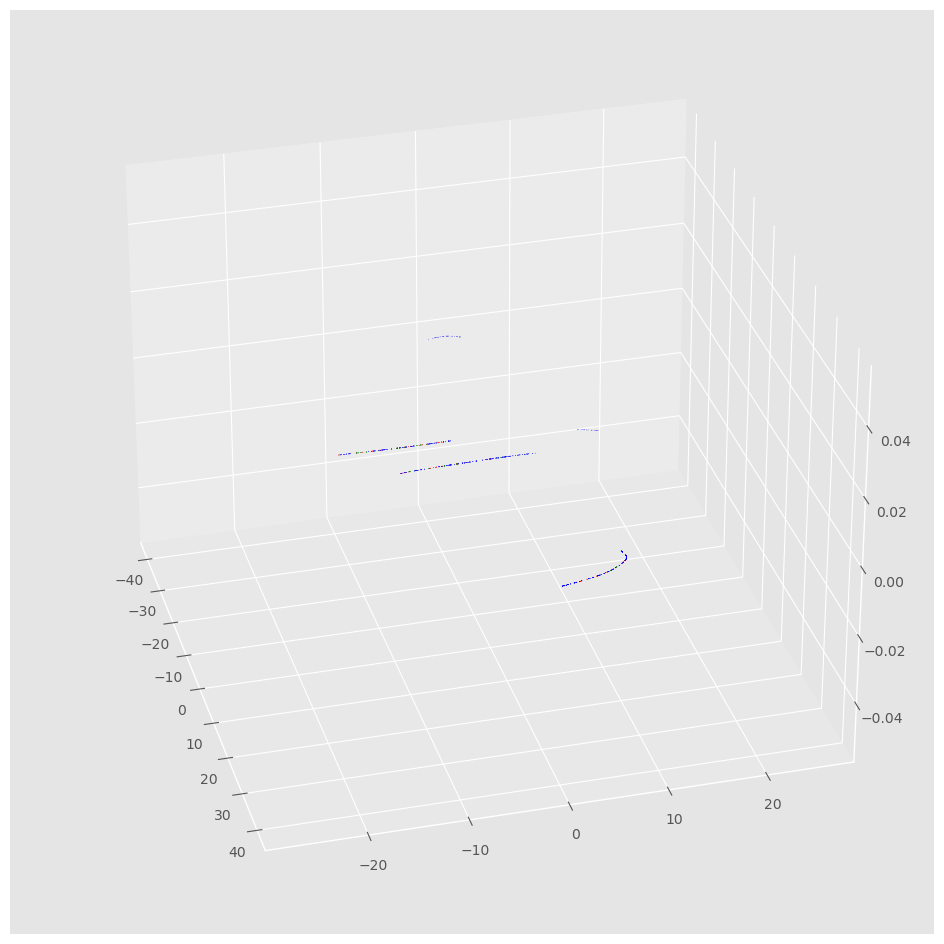

In [48]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')


plt.style.use('ggplot')
# Load your data
X = emb

# Create a t-SNE model with 2 components
tsne = TSNE(n_components=3, random_state=0)

# Fit and transform the data to the 2D t-SNE space
X_2d = tsne.fit_transform(X)


t=366
# Plot the data in the 2D t-SNE space
plt.scatter(X_2d[:t,0], X_2d[:t,1], X_2d[:t,2], c='red', cmap='viridis')
plt.scatter(X_2d[t*2:,0], X_2d[t*2:,1], X_2d[t*2:,2], c='blue', cmap='viridis')
plt.scatter(X_2d[t:t*2,0], X_2d[t:t*2,1], X_2d[t:t*2,2], c='green', cmap='viridis')
# plt.scatter(X_2d[t*3:t*4,0], X_2d[t*3:t*4,1], c='yellow', cmap='viridis') 
# plt.scatter(X_2d[t*4:t*5,0], X_2d[t*4:t*5,1], c='black', cmap='viridis')
# plt.scatter(X_2d[t*5:t*6,0], X_2d[t*5:t*6,1], c='orange', cmap='viridis')

ax.view_init(elev=30, azim=-15)


plt.show()

/tmp/ipykernel_296/378083627.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[:t,0], X_2d[:t,1], c='red', cmap='viridis')
/tmp/ipykernel_296/378083627.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[t*2:,0], X_2d[t*2:,1], c='blue', cmap='viridis')
/tmp/ipykernel_296/378083627.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[t:t*2,0], X_2d[t:t*2,1], c='green', cmap='viridis')


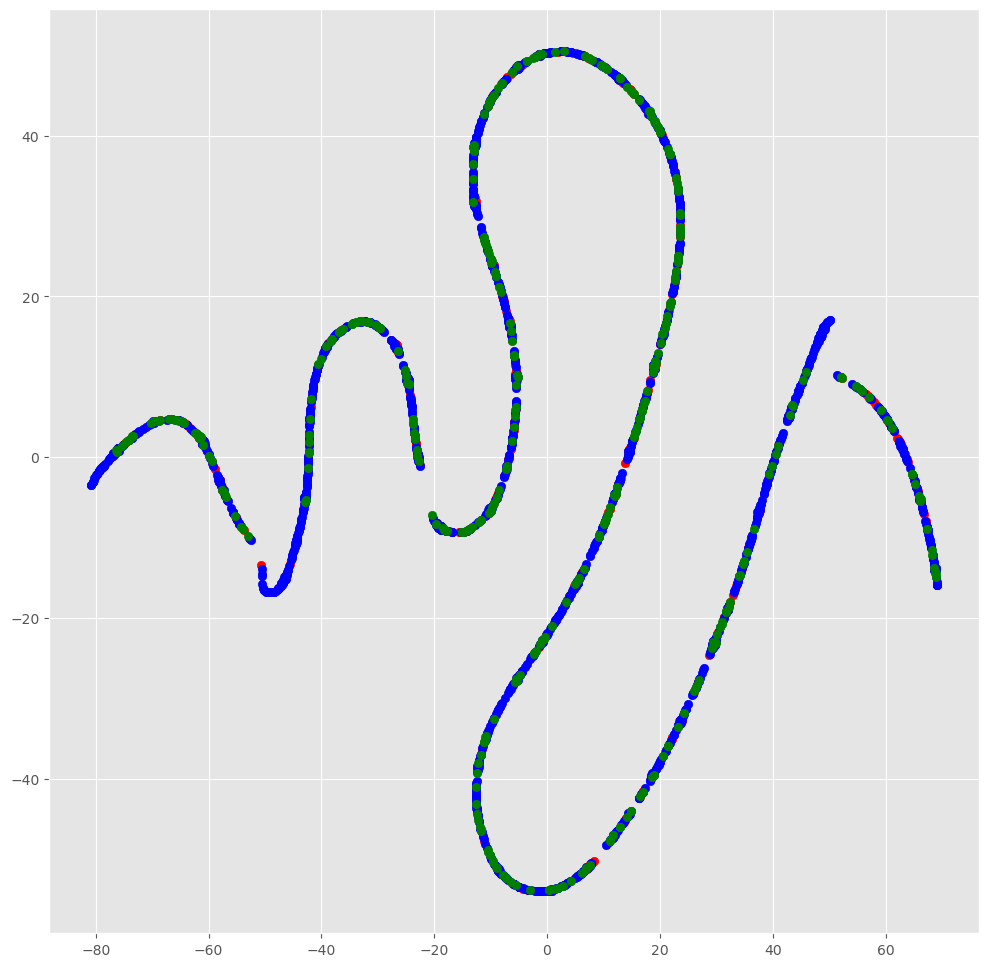

In [49]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12, 12))


plt.style.use('ggplot')
# Load your data
X = emb

# Create a t-SNE model with 2 components
tsne = TSNE(n_components=2, random_state=28)

# Fit and transform the data to the 2D t-SNE space
X_2d = tsne.fit_transform(X)

t = 366
# Plot the data in the 2D t-SNE space
plt.scatter(X_2d[:t,0], X_2d[:t,1], c='red', cmap='viridis')
plt.scatter(X_2d[t*2:,0], X_2d[t*2:,1], c='blue', cmap='viridis')
plt.scatter(X_2d[t:t*2,0], X_2d[t:t*2,1], c='green', cmap='viridis')
# plt.scatter(X_2d[t*3:t*4,0], X_2d[t*3:t*4,1], c='yellow', cmap='viridis')
# plt.scatter(X_2d[t*4:t*5,0], X_2d[t*4:t*5,1], c='black', cmap='viridis')
# plt.scatter(X_2d[t*5:t*6,0], X_2d[t*5:t*6,1], c='orange', cmap='viridis')

# plt.scatter(X_2d[0,0], X_2d[0,1], c='red', cmap='viridis')
# plt.scatter(X_2d[1,0], X_2d[1,1], c='blue', cmap='viridis')
# plt.scatter(X_2d[2,0], X_2d[2,1], c='green', cmap='viridis')
# plt.scatter(X_2d[3,0], X_2d[3,1], c='purple', cmap='viridis')
# plt.scatter(X_2d[4,0], X_2d[4,1], c='orange', cmap='viridis')


plt.show()

/tmp/ipykernel_296/2779864115.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[0,0], X_2d[0,1], c='red', cmap='viridis')
/tmp/ipykernel_296/2779864115.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[1,0], X_2d[1,1], c='blue', cmap='viridis')
/tmp/ipykernel_296/2779864115.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[2,0], X_2d[2,1], c='green', cmap='viridis')
/tmp/ipykernel_296/2779864115.py:35: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[3,0], X_2d[3,1], c='purple', cmap='viridis')
/tmp/ipykernel_296/2779864115.py:37: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_2d[4,0], X_2d[4,1], c='orange', cmap='viridis')
/tmp/ipykernel_296/2779864115.py:38: UserWarning: N

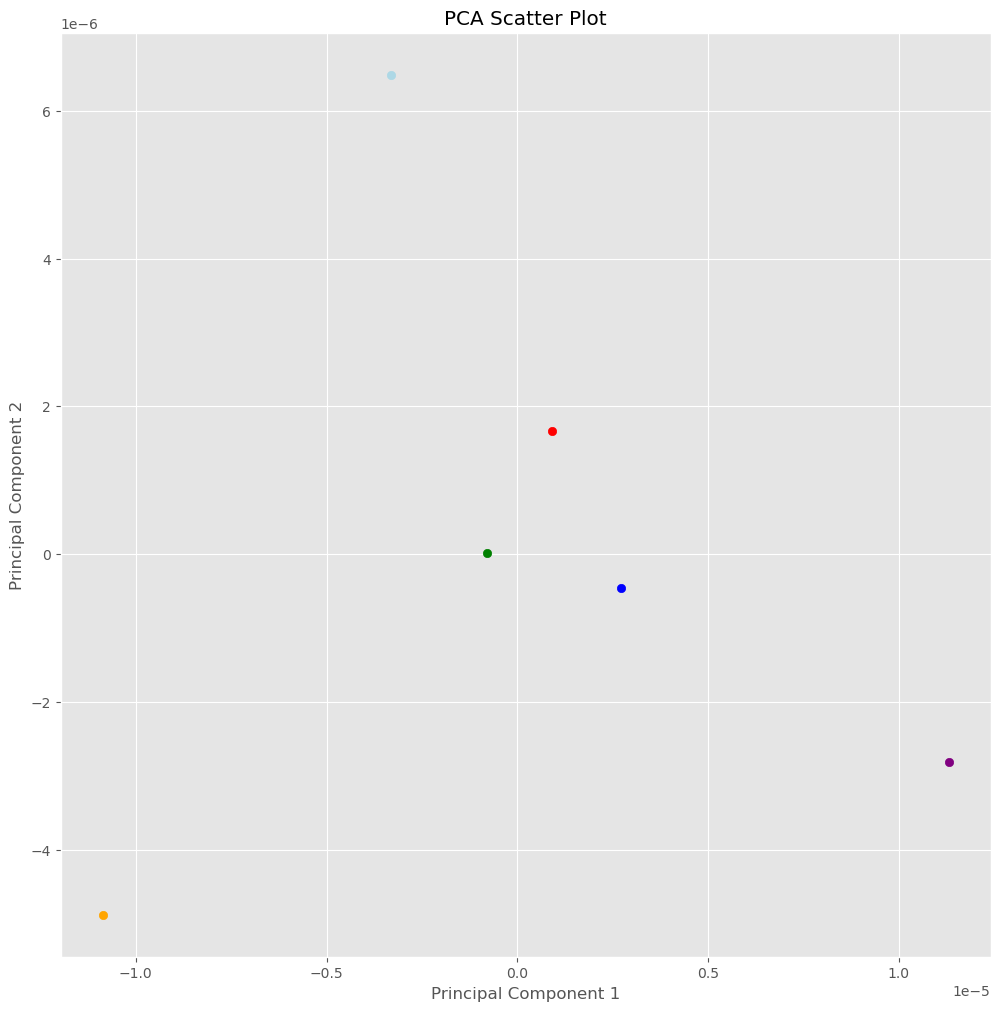

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Combine the data into a dataframe
data = pd.DataFrame(emb)

fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# Perform PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(data)

# Create a scatter plot of the principal components
# Plot the data in the 2D t-SNE space
# plt.scatter(X_2d[:72,0], X_2d[:72,1], c='red', cmap='viridis')
# plt.scatter(X_2d[72:,0], X_2d[72:,1], c='blue', cmap='viridis')
# plt.scatter(X_2d[72+72:,0], X_2d[72+72:,1], c='green', cmap='viridis')
# plt.scatter(X_2d[72+72+70:,0], X_2d[72+72+70:,1], c='purple', cmap='viridis')
# plt.scatter(X_2d[72+72+70+15:,0], X_2d[72+72+70+15:,1], c='orange', cmap='viridis')

# plt.scatter(X_2d[:72,0], X_2d[:72,1], X_2d[:72,2], c='red', cmap='viridis')
# plt.scatter(X_2d[72:,0], X_2d[72:,1], X_2d[72:,2], c='blue', cmap='viridis')
# plt.scatter(X_2d[72+72:,0], X_2d[72+72:,1], X_2d[72+72:,2], c='brown', cmap='viridis')
# plt.scatter(X_2d[72+72+70:,0], X_2d[72+72+70:,1], X_2d[72+72+70:,2], c='purple', cmap='viridis')
# plt.scatter(X_2d[72+72+70+15:,0], X_2d[72+72+70+15:,1], X_2d[72+72+70+15:,2], c='orange', cmap='viridis')

plt.scatter(X_2d[0,0], X_2d[0,1], c='red', cmap='viridis')
plt.scatter(X_2d[1,0], X_2d[1,1], c='blue', cmap='viridis')

plt.scatter(X_2d[2,0], X_2d[2,1], c='green', cmap='viridis')
plt.scatter(X_2d[3,0], X_2d[3,1], c='purple', cmap='viridis')

plt.scatter(X_2d[4,0], X_2d[4,1], c='orange', cmap='viridis')
plt.scatter(X_2d[5,0], X_2d[5,1], c='lightblue', cmap='viridis')

# Add axis labels and a title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')

# plt.xscale('symlog')
# Display the plot
plt.show()